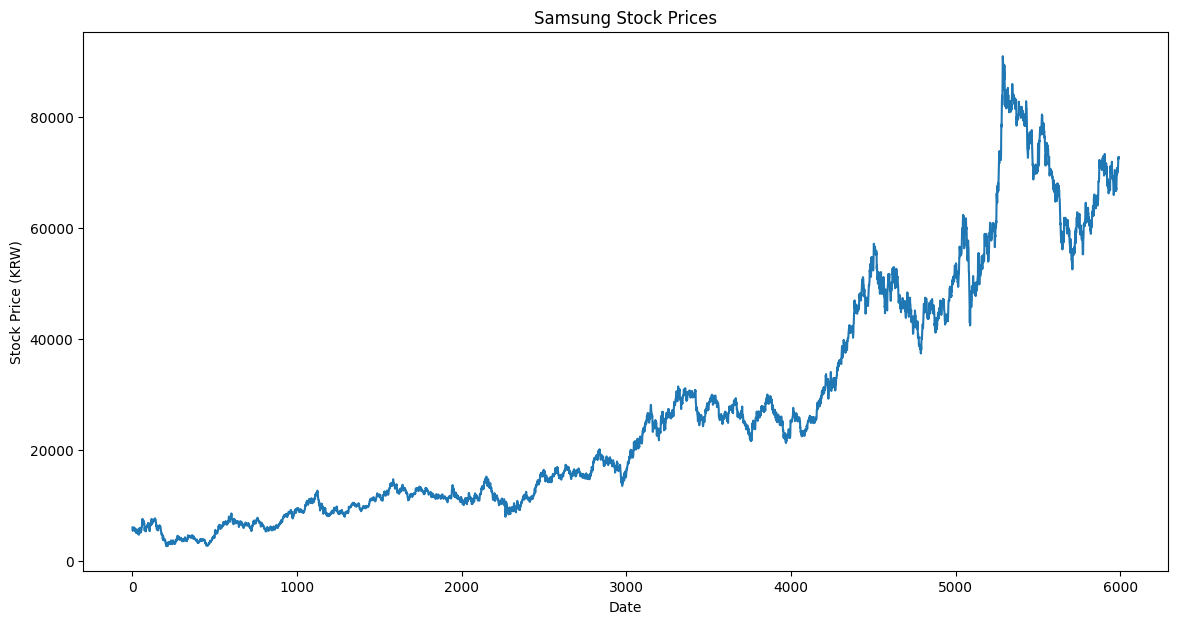

In [1]:
!pip install keras-self-attention
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from keras_self_attention import SeqSelfAttention
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Flatten
data = "https://raw.githubusercontent.com/Rifat-87/Assignment-3-RNN/main/005930.KS.csv"
df = pd.read_csv(data)
df.head()
plt.figure(figsize=(14, 7))
plt.title('Samsung Stock Prices')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price (KRW)')
plt.show()



In [2]:
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)


train_size = int(len(data_normalized) * 0.8)
test_size = len(data_normalized) - train_size
train, test = data_normalized[0:train_size, :], data_normalized[train_size:len(data_normalized), :]


In [3]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length), 0]
        target = data[i + seq_length, 0]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

seq_length = 10


X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


In [ ]:
#LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(1, seq_length)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

#GRU
gru_model = Sequential()
gru_model.add(GRU(50, input_shape=(1, seq_length)))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

#Bidirectional
bidirectional_model = Sequential()
bidirectional_model.add(Bidirectional(LSTM(50, input_shape=(1, seq_length))))
bidirectional_model.add(Dense(1))
bidirectional_model.compile(loss='mean_squared_error', optimizer='adam')
bidirectional_model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

#Transformer
transformer_model = Sequential()
transformer_model.add(SeqSelfAttention(attention_activation='sigmoid'))
transformer_model.add(Dense(1))
transformer_model.compile(loss='mean_squared_error', optimizer='adam')
transformer_model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)


In [ ]:
def mean_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true) * 100

def directional_accuracy(y_true, y_pred):
    y_true_diff = np.diff(y_true.flatten())
    y_pred_diff = np.diff(y_pred.flatten())
    correct_direction = np.sum(np.sign(y_true_diff) == np.sign(y_pred_diff))
    total_directions = len(y_true_diff)
    return correct_direction / total_directions * 100

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)
bidirectional_predictions = bidirectional_model.predict(X_test)
transformer_predictions = transformer_model.predict(X_test)

lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)
bidirectional_predictions = scaler.inverse_transform(bidirectional_predictions)
transformer_predictions = transformer_predictions.reshape(-1, 1)
transformer_predictions = scaler.inverse_transform(transformer_predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

def evaluate_model(predictions, model_name):
    mse = mean_squared_error(y_test_original, predictions)
    mae = mean_absolute_error(y_test_original, predictions)
    mpe = mean_percentage_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)
    rmse = sqrt(mean_squared_error(y_test_original, predictions))
    da = directional_accuracy(y_test_original, predictions)

    print(f"{model_name} Metrics:")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Directional Accuracy (DA): {da}")
    print(f"Mean Percentage Error (MPE): {mpe}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")

    print("\n")

evaluate_model(lstm_predictions, "LSTM")
evaluate_model(gru_predictions, "GRU")
evaluate_model(bidirectional_predictions, "Bidirectional RNN")
evaluate_model(transformer_predictions, "Transformer")

def plot_predictions(y_true, predictions, model_name):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true, label='True Values', color='black')
    plt.plot(predictions, label=f'{model_name} Predictions', linestyle='dashed')
    plt.title(f'{model_name} - Stock Price Predictions')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


plot_predictions(y_test_original, lstm_predictions, "LSTM")
plot_predictions(y_test_original, gru_predictions, "GRU")
plot_predictions(y_test_original, bidirectional_predictions, "Bidirectional RNN")
plot_predictions(y_test_original, transformer_predictions, "Transformer")

plt.figure(figsize=(15, 6))
plt.plot(y_test_original, label='True Values', color='black')
plt.plot(lstm_predictions, label='LSTM Predictions', linestyle='dashed')
plt.plot(gru_predictions, label='GRU Predictions', linestyle='dashed')
plt.plot(bidirectional_predictions, label='Bidirectional RNN Predictions', linestyle='dashed')
plt.plot(transformer_predictions, label='Transformer Predictions', linestyle='dashed')
plt.title('Stock Price Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
models = ['LSTM', 'GRU', 'Bidirectional RNN', 'Transformer']
rmse_values = [4336.216174628624, 3295.8418819751373, 3360.1950886644554, 1026.2211170316698]
mse_values = [18802770.713110894, 10862573.710981416, 11290911.033884726, 1053129.7810417283]
mae_values = [3614.644166579058, 2458.102574379731, 2385.759698275862, 772.7947953900336]
da_values = [48.4006734006734, 48.90572390572391, 48.98989898989899, 46.801346801346796]
mpe_values = [5.2662603568183375, 3.1930197928329496, 2.209997689410864, -0.005799476243559228]
mape_values = [5.310368066648106, 3.4899149078691174, 3.389314916721041, 1.253665811931803]


fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Model Comparison Metrics')

axs[0, 0].bar(models, rmse_values, color='blue')
axs[0, 0].set_title('Root Mean Squared Error (RMSE)')

axs[0, 1].bar(models, mse_values, color='green')
axs[0, 1].set_title('Mean Squared Error (MSE)')

axs[0, 2].bar(models, mae_values, color='orange')
axs[0, 2].set_title('Mean Absolute Error (MAE)')

axs[1, 0].bar(models, da_values, color='red')
axs[1, 0].set_title('Directional Accuracy (DA)')

axs[1, 1].bar(models, mpe_values, color='purple')
axs[1, 1].set_title('Mean Percentage Error (MPE)')

axs[1, 2].bar(models, mape_values, color='brown')
axs[1, 2].set_title('Mean Absolute Percentage Error (MAPE)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
def create_sequences_with_diff(data, seq_length):
    X, y_diff = [], []
    for i in range(len(data) - seq_length - 1):
        seq = data[i:(i + seq_length), 0]
        target_diff = data[i + seq_length + 1, 0] - data[i + seq_length, 0]
        X.append(seq)
        y_diff.append(target_diff)
    return np.array(X), np.array(y_diff)
seq_length = 10


X_train_diff, y_train_diff = create_sequences_with_diff(train, seq_length)
X_test_diff, y_test_diff = create_sequences_with_diff(test, seq_length)

X_train_diff = np.reshape(X_train_diff, (X_train_diff.shape[0], 1, X_train_diff.shape[1]))
X_test_diff = np.reshape(X_test_diff, (X_test_diff.shape[0], 1, X_test_diff.shape[1]))

lstm_model_diff = Sequential()
lstm_model_diff.add(LSTM(50, input_shape=(1, seq_length)))
lstm_model_diff.add(Dense(1))
lstm_model_diff.compile(loss='mean_squared_error', optimizer='adam')
lstm_model_diff.fit(X_train_diff, y_train_diff, epochs=5, batch_size=1, verbose=2)

gru_model_diff = Sequential()
gru_model_diff.add(GRU(50, input_shape=(1, seq_length)))
gru_model_diff.add(Dense(1))
gru_model_diff.compile(loss='mean_squared_error', optimizer='adam')
gru_model_diff.fit(X_train_diff, y_train_diff, epochs=5, batch_size=1, verbose=2)

bidirectional_model_diff = Sequential()
bidirectional_model_diff.add(Bidirectional(LSTM(5, input_shape=(1, seq_length))))
bidirectional_model_diff.add(Dense(1))
bidirectional_model_diff.compile(loss='mean_squared_error', optimizer='adam')
bidirectional_model_diff.fit(X_train_diff, y_train_diff, epochs=5, batch_size=1, verbose=2)

transformer_model_diff = Sequential()
transformer_model_diff.add(SeqSelfAttention(attention_activation='sigmoid'))
transformer_model_diff.add(Dense(1))
transformer_model_diff.compile(loss='mean_squared_error', optimizer='adam')
transformer_model_diff.fit(X_train_diff, y_train_diff, epochs=5, batch_size=1, verbose=2)



In [ ]:
lstm_predictions_diff = lstm_model_diff.predict(X_test_diff)
gru_predictions_diff = gru_model_diff.predict(X_test_diff)
bidirectional_predictions_diff = bidirectional_model_diff.predict(X_test_diff)
transformer_predictions_diff = transformer_model_diff.predict(X_test_diff)
lstm_predictions_diff = scaler.inverse_transform(lstm_predictions_diff)
gru_predictions_diff = scaler.inverse_transform(gru_predictions_diff)
bidirectional_predictions_diff = scaler.inverse_transform(bidirectional_predictions_diff)
transformer_predictions_diff = transformer_predictions_diff.reshape(-1, 1)
transformer_predictions_diff = scaler.inverse_transform(transformer_predictions_diff)
y_test_original_diff = scaler.inverse_transform(y_test_diff.reshape(-1, 1))
def mean_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true) * 100

def directional_accuracy(y_true, y_pred):
    y_true_diff = np.diff(y_true.flatten())
    y_pred_diff = np.diff(y_pred.flatten())
    correct_direction = np.sum(np.sign(y_true_diff) == np.sign(y_pred_diff))
    total_directions = len(y_true_diff)
    return correct_direction / total_directions * 100

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model_diff(predictions, y_true, model_name):
    mse = mean_squared_error(y_true, predictions)
    mae = mean_absolute_error(y_true, predictions)
    mpe = mean_percentage_error(y_true, predictions)
    da = directional_accuracy(y_true, predictions)
    mape = mean_absolute_percentage_error(y_true, predictions)

    print(f"{model_name} Metrics for Price Differences:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Percentage Error (MPE): {mpe}")
    print(f"Directional Accuracy (DA): {da}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}")
    print("\n")

def plot_predictions(y_true, predictions, model_name):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true, label='True Values', color='black')
    plt.plot(predictions, label=f'{model_name} Predictions', linestyle='dashed')
    plt.title(f'{model_name} - Stock Price Differences Predictions')
    plt.xlabel('Time')
    plt.ylabel('Stock Price Differences')
    plt.legend()
    plt.show()

evaluate_model_diff(lstm_predictions_diff, y_test_original_diff, "LSTM (Price Differences)")
evaluate_model_diff(gru_predictions_diff, y_test_original_diff, "GRU (Price Differences)")
evaluate_model_diff(bidirectional_predictions_diff, y_test_original_diff, "Bidirectional RNN (Price Differences)")
evaluate_model_diff(transformer_predictions_diff, y_test_original_diff, "Transformer (Price Differences)")


plot_predictions(y_test_original_diff, lstm_predictions_diff, "LSTM (Price Differences)")
plot_predictions(y_test_original_diff, gru_predictions_diff, "GRU (Price Differences)")
plot_predictions(y_test_original_diff, bidirectional_predictions_diff, "Bidirectional RNN (Price Differences)")
plot_predictions(y_test_original_diff, transformer_predictions_diff, "Transformer (Price Differences)")
